In [1]:
# Lib para manipulação de dados
import numpy as np
import pandas as pd

# IO bibliotecas
import os
import csv

# Visualização de progressão para laços
import seaborn as sns
import matplotlib.pyplot as plt

# regex
import re

# NLTK - Biblioteca com ferramentas para processamento de linguagem natural.
# Util para todos os tipos de tarefas de tokenização, stemming, tagging e parsing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Remoção de acentos gráficos
import unidecode

# Pipeline
from sklearn.pipeline import Pipeline

# Libs para metricas e avaliação
import sklearn.metrics as metrics
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection as ms

# WordCloud
from wordcloud import WordCloud

from random import randint

In [2]:
# Carregar os twetters sobre o estado de minas gerais
twetter_df = pd.read_csv("./archive/tw_pt.csv")
twetter_df.head()


,Unnamed: 0,Text,Classificacao
0,0,���⛪ @ Catedral de Santo Antônio - Governador ...,Neutro
1,1,"� @ Governador Valadares, Minas Gerais https:/...",Neutro
2,2,"�� @ Governador Valadares, Minas Gerais https:...",Neutro
3,3,��� https://t.co/BnDsO34qK0,Neutro
4,4,��� PSOL vai questionar aumento de vereadores ...,Negativo


# StopWords Remoção
<p> A remoção dos stopWords serve para que o algoritmo de machine learning foque nas frases principais e não nas mais comuns usadas pela lingua <p/>

In [3]:
# Download das extensões necessárias
nltk.download("stopwords")
nltk.download('punkt')

# Configurando para a lingua portuguesa
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Breno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Breno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def removerStopWords(texto):
    #Tokenização
    word_tokens =  word_tokenize(texto)
    ps = PorterStemmer()
    steamming_words = []
    
    for word in word_tokens:
        steamming_words.append(ps.stem(word))
    
    #Limpa os tokens removendo as stopwords da lingua portuguesa e converte para string.
    sentencas_filtradas =  ' '.join([p for p in steamming_words if not p.lower() in stop_words])         
    
    # Função strip remove os espaços em branco no começo e no fim da string.
    return sentencas_filtradas.strip()    

In [5]:
def removerCaracteresEspeciais(Text):
    Text = unidecode.unidecode(Text)
    Text = re.sub(r'http\S+|[0-9]|\.|\,|\-|\_|\:|\;|\@|\#|\!|\>|\<|\&|\®', '', Text)
    Text = removerStopWords(Text)
    Text = Text.lower().strip()
    
    return Text

In [6]:
def limparTexto(dataFrame):
    result =  pd.DataFrame()
    #Percorrer data linha do data frame
    for row in dataFrame.itertuples(index=True, name="Pandas"):
        Text = row.Text
        Classificacao = row.Classificacao
        
        #Realiza a limpeza de caracteres indesejados no texto.
        Text =  removerCaracteresEspeciais(Text)
    
        # Cria um novo dataframe e o concatena ao existente. 
        linha = pd.Series([Text, Classificacao])        
        linha = pd.DataFrame([linha])        
        result = pd.concat([linha, result], ignore_index=True)       
    
    return result

In [7]:
twetter_df_clean =  limparTexto(twetter_df).rename(columns= {0: 'Text', 1: "Classificacao"})

#Remoção dos dados duplicados
twetter_df_clean.drop_duplicates(subset='Text',inplace=True)
print(twetter_df_clean.describe())

                                                     Text Classificacao
count                                                3585          3585
unique                                               3585             3
top     trio suspeito roubo carga preso santa luzia ( ...        Neutro
freq                                                    1          1523


In [8]:
def calcularMetricas(y_test, predict):
    '''
    Calcular as métricas de acuracia, precisão, recal, micro e macro f1
    '''
    acuracia = metrics.accuracy_score(y_test, predict)
    precision = metrics.precision_score(y_test, predict, average='weighted')
    recal = metrics.recall_score(y_test, predict, average='weighted')
    micro_f1 = metrics.f1_score(y_test, predict, average='micro')
    macro_f1 = metrics.f1_score(y_test, predict, average='macro')
    
    print(10*"-"," PONDERAÇÂO ", 10*"-",)
    metricas(acuracia, precision, recal, micro_f1, macro_f1)

In [9]:

def metricas(acuracia, precision, recal, micro_f1, macro_f1):
    '''
    Printar as métricas
    '''
    print(f'Acurácia: %.2f' % (acuracia*100))
    print(f'precision: %.2f' % (precision*100))
    print(f'recal: %.2f' % (recal*100))
    print(f'micro-f1: %.2f' % (micro_f1*100))
    print(f'macro-f1: %.2f' % (macro_f1*100))


# Naive Bayes

In [10]:
x = twetter_df_clean['Text']
y = twetter_df_clean['Classificacao']

# treino e teste
X_train, X_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.60, random_state=48)

# Pipeline para realizar o tf-idf e treinar o modelo
pipe =  Pipeline([('vectorizer',TfidfVectorizer(analyzer='word')),('naive', MultinomialNB())])

pipe.fit(X_train, y_train)

# predicão
predicts = pipe.predict(X_test)

# Predição probabilidade
predicts_proba = pipe.predict_proba(X_test)

# Calcular as métricas
calcularMetricas(y_test, predicts)

----------  PONDERAÇÂO  ----------
Acurácia: 87.26
precision: 87.57
recal: 87.26
micro-f1: 87.26
macro-f1: 85.15


# Matriz de Confusão

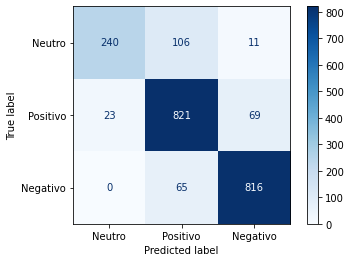

In [11]:
cm = metrics.confusion_matrix(y_test, predicts)
cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=y_test.unique()).plot(cmap='Blues')

In [12]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None,):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
        
    sns.lineplot(x = fpr, y = tpr, ax = ax, legend="brief")
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

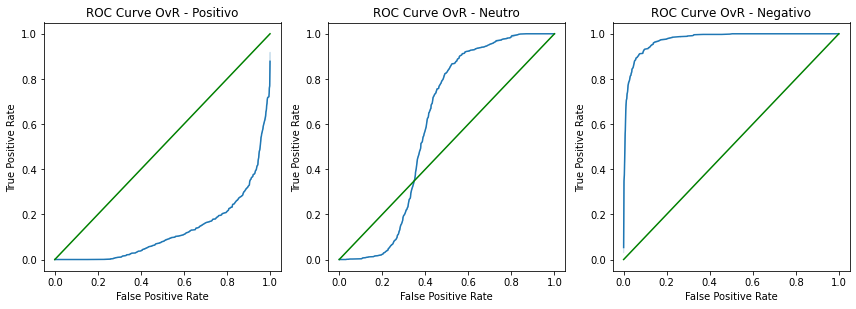

In [13]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
# Utilizando a metodologia OvR One vs Rest ou Um versus o resto

plt.figure(figsize=(12, 8))
classes = twetter_df_clean.Classificacao.unique()
roc_auc_ovr = {}

# Calcula a curva ROC para cada tipo de calculo da bag of words

for i in range(len(classes)):
    # Recupera a classe
    classe = classes[i]

    # Verificar
    list_class = [1 if y == classe else 0 for y in y_test]
    list_prob = predicts_proba[:, 0]
    data = {"class": list_class, "prob": list_prob}
    df_aux = pd.DataFrame(data)

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i+4)
    # tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])

    fpr, tpr, thresholds = metrics.roc_curve(list_class, list_prob)
    plot_roc_curve(tpr, fpr, scatter=False, ax=ax_bottom)
    ax_bottom.set_title(f"ROC Curve OvR - {classe}")

    # Calculates the ROC AUC OvR
    roc_auc_ovr[i] = metrics.roc_auc_score(df_aux['class'], df_aux['prob'])


plt.tight_layout()


In [14]:
# PREDICST PROB ->  NEGATIVO, NEUTRO, POSITIVO,
prob_negativo = predicts_proba[:,0]
prob_neutro = predicts_proba[:,1]
prob_positivo = predicts_proba[:,2]


df_words_prob =  pd.DataFrame({
            'Texto': X_test,
            'Prob_Negativo': prob_negativo,
            'Prob_Neutro': prob_neutro,
            'Prob_Positivo': prob_positivo
            })


In [15]:
palavras_proibidas = ['trafico','droga','roubo','furto','arma','preso', 'traficant','presa','presos']

In [21]:
def escolherPalavra(texto_splited, classificacao):
    palavraPermitida = False
    palavra = ''
    while(not palavraPermitida):
        random_index = randint(0,  len(texto_splited) - 1)
        palavra = texto_splited[random_index]
        if(palavra not in palavras_proibidas):
            palavraPermitida = True

    return palavra


In [22]:
# CRIAR UM LAÇO PARA RECUPERAR ESSAS INFORMAÇÕES E MONTAR O WORD CLOUD
for nomeClasse in classes:
    palavras = []
    df_words = df_words_prob.sort_values(
        f'Prob_{nomeClasse}', ascending=False).iloc[0:130]

    for texto in df_words.Texto:
        word_splited = texto.split()
        if len(word_splited) > 0:
            termo_escolhido = escolherPalavra(word_splited, nomeClasse)
            palavras.append(termo_escolhido)
            palavras_usadas.append(termo_escolhido)
            

    plt.figure(figsize = (10, 10))
    word_cloud =  WordCloud(collocations=False, background_color='white').generate(" ".join(palavras))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    
    print(f"Nuvem de palavras {nomeClasse}")
    plt.show()

KeyboardInterrupt: 